In [1]:
from transformers import BertForSequenceClassification, BertTokenizer, RobertaTokenizerFast, RobertaForSequenceClassification, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, XLNetForSequenceClassification, XLNetTokenizerFast
from transformers import AutoTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython import display
import numpy as np



In [2]:
# helper method to plot loss curves


def plot_loss(output_losses, val_losses, epochs, dynamic):
    x=np.arange(len(output_losses))

    y_output=np.array(output_losses)
    y_val=np.array(val_losses)

    print(x, x.shape) # 2
    print(y_output, y_output.shape) # 2
    print(y_val, y_val.shape) # 1


    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.plot(x, y_output, label='Training Loss', color='b')
    plt.plot(x, y_val, label='Validation Loss', color='r')

    plt.legend()
    plt.show()

    plt.pause(0.5)

    display.display(plt.gcf())
    if dynamic:
        display.clear_output(wait=True)






In [3]:
import chardet

with open("data.csv", "rb") as f:
    result = chardet.detect(f.read())


In [4]:
# read data 
data = pd.read_csv("data.csv", encoding='windows-1252')


In [5]:
global EPOCHS, LR, BATCH_SIZE, EVAL_EVERY, SEED
EPOCHS=10
LR=1e-5
BATCH_SIZE=15
SEED=123

In [6]:
# split data into training and testing

training_set, testing_set = train_test_split(data, test_size=0.2, train_size=0.8, random_state=SEED)




In [7]:


# preprocess data

# extract sentences and labels from datasata
def preprocess(data):
    sentences=data['sentences'].tolist()

    sentiment_labels_dict={'dovish':0, 'hawkish':1, 'neutral':2, 'irrelevant':3}
    sentiment_labels_encoded=[]
    for sentiment_label in data['sentiment_label']:
        sentiment_labels_encoded.append(sentiment_labels_dict[sentiment_label]) # tensor can only hold ints


    # tokensize and return TensorDataset

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # encodes the data such that the model can process it
    tokens=tokenizer(sentences, return_tensors='pt', padding=True, truncation=True, max_length=256) # pytorch tensor
    
    return TensorDataset(tokens['input_ids'], tokens['attention_mask'], torch.LongTensor(sentiment_labels_encoded))




In [8]:
# dataloaders

train_dataloader=DataLoader(preprocess(training_set), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(preprocess(testing_set), batch_size=BATCH_SIZE, shuffle=False)

batch = next(iter(test_dataloader))
x1, x2, x3 = batch 
# print(f"X1: {(x1.size())}....X2: {x2.size()}....X3: {x3.size()}")
# print(f"X1: {(type(x1))}....X2: {type(x2)}....X3: {type(x3)}")


      
# print(f"Test Features {test_features}, Test Labels {test_labels}")

c:\Users\riyaa\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# training loop

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4) # doing model=BertForSequenceClassification passes in the class itself not an instance of the class

def training_loop(PLOT_LOSSES=True):

    optimizer=optim.AdamW(model.parameters(), lr=LR)
    loss=nn.CrossEntropyLoss()

    training_losses=[]
    val_loss_list=[]

    for i in range(EPOCHS+1):
        total_loss=0
        model.train() # training mode (there are two modes: training and evaluation)
        for batch in train_dataloader:
            inputs, masks, labels = batch # input_id is tokenized form of input, attention_mask: which tokens refer to an item in the dataset and which is padding, etc
            
            # print("Labels:", labels)

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask=masks, labels=labels) # forward pass, stores predictions
            loss=outputs.loss # calculating loss
            loss.backward() # backward pass, computes gradients
            optimizer.step() # adjust weights
            total_loss+=loss.item()
        
        training_losses.append(total_loss/len(train_dataloader)) # average loss for each epoch across batches


        # running model on testing data

        model.eval()
        with torch.no_grad(): # not calculated gradients
            val_loss=0.0
            val_f1_score, val_precision_score, val_recall_score=0,0,0
            for batch in test_dataloader:
                
                val_inputs, val_masks, val_labels = batch
                val_outputs = model(val_inputs, attention_mask=val_masks, labels=val_labels)
                

                val_loss += val_outputs.loss.item()
                
                val_outputs=val_outputs.logits.argmax(dim=1) #f1 calculation needs 1D tensor, class size x batch size (class size = 4, in this case)
                val_f1_score += f1_score(val_outputs, val_labels, average='weighted')
                val_precision_score += precision_score(val_outputs, val_labels, average='weighted')
                val_recall_score += recall_score(val_outputs, val_labels, average='weighted', zero_division=0.0)

            val_loss_list.append(val_loss/len(test_dataloader))
            
            val_f1_score=val_f1_score/len(test_dataloader)
            val_precision_score=val_precision_score/len(test_dataloader)
            val_recall_score=val_recall_score/len(test_dataloader)
            print(f"Validation Loss: {sum(val_loss_list)/len(val_loss_list)}, F1: {val_f1_score}, Precision: {val_precision_score}, Recall: {val_recall_score}")

            if PLOT_LOSSES:
                plot_loss(training_losses, val_loss_list, EPOCHS, dynamic=True)
                

    
    if PLOT_LOSSES:
        plot_loss(training_losses, val_loss_list, EPOCHS, dynamic=False)
    
    return model, loss, optimizer, training_losses, val_loss_list



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ 0  1  2  3  4  5  6  7  8  9 10] (11,)
[1.25226513 1.11554926 1.07312365 0.96625941 0.85347433 0.68813908
 0.55059917 0.42454975 0.31147614 0.22392073 0.16543222] (11,)
[1.14644204 1.10962577 1.09043762 1.07968934 1.1168275  1.1468647
 1.18024784 1.27565531 1.36532443 1.46356484 1.47922954] (11,)


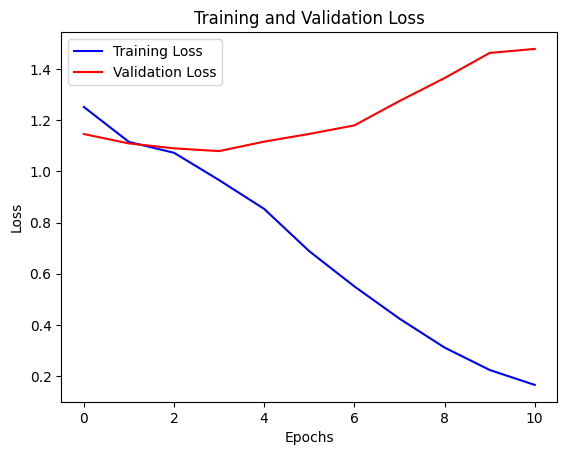

<Figure size 640x480 with 0 Axes>

(BertForSequenceClassification(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (token_type_embeddings): Embedding(2, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): BertEncoder(
       (layer): ModuleList(
         (0-11): 12 x BertLayer(
           (attention): BertAttention(
             (self): BertSdpaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): BertSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (LayerNorm): La

<Figure size 640x480 with 0 Axes>

In [10]:
training_loop(PLOT_LOSSES=True)